In [1]:
import numpy as np
from PIL import Image # 파일 이미치 처리
import glob # 파일 채로 묶어서 처리하기 위함

In [2]:
# Names
dirNames = ['Aiden','Andrew','Cathy']

### 사진들을 numpy배열을 이용하여 Training Data 만들기

In [3]:
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 400

In [5]:
train = np.zeros(number_of_data * img_width_size * img_height_size, dtype=np.int32).reshape(number_of_data,img_height_size,img_width_size)
i = 0

for name in dirNames:
    for file in sorted(glob.glob("../Data/FaceGray/%s/*.jpg"%name)):
        img = np.array(Image.open(file),dtype=np.int32)
        train[i,:,:] = img
        i += 1

In [6]:
train.shape

(54, 400, 300)

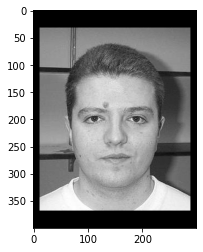

In [7]:
# 이미지 확인하기

import matplotlib.pyplot as plt

plt.imshow(train[0].reshape(400,300),cmap='gray')
plt.show()

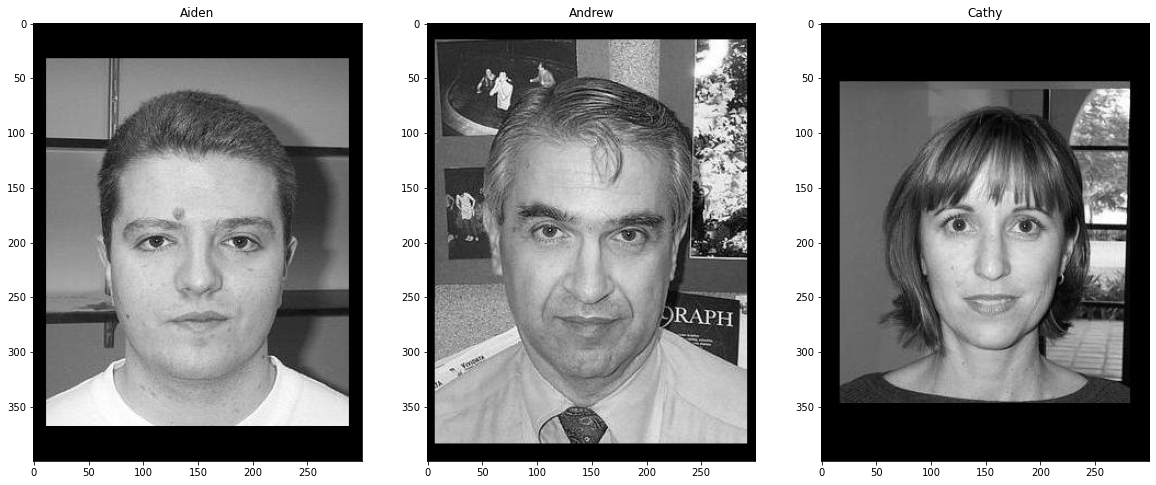

In [10]:
plt.figure(figsize=(20,20))
orderNo = list(range(0,len(dirNames) * 18, 18))
orderNo

for i in list(range(1,len(dirNames)+1)):
    plt.subplot(1,len(dirNames),i)
    plt.imshow(train[orderNo[i-1]].reshape(400,300),cmap='gray')
    plt.title(dirNames[i-1])

### target Data 만들기

In [11]:
# Aiden : 0 , Andrew : 1, Cathy : 2
target = np.concatenate([np.zeros(18),np.ones(18),np.full(18,2)])
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

---
### train과 test로 분류하기

In [12]:
train = train.reshape(-1,400,300,1) / 255.0

In [13]:
from sklearn.model_selection import train_test_split

trainData, valData, trainTargetData,valTargetData = train_test_split(
    train,target,test_size=0.2,random_state=42
)

In [15]:
print(trainData.shape)
print(valData.shape)
print(trainTargetData.shape)
print(valTargetData.shape)

(43, 400, 300, 1)
(11, 400, 300, 1)
(43,)
(11,)


---
# CNN 만들기

In [27]:
from tensorflow import keras

model = keras.Sequential()

In [28]:
model.add(keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same',input_shape=(400,300,1)))

In [29]:
model.add(keras.layers.MaxPooling2D(2))

In [30]:
model.add(keras.layers.Conv2D(64,kernel_size=3,activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [31]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(len(dirNames),activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 400, 300, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 200, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 150, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 75, 64)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 480000)            0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [33]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
chekpoint_cb = keras.callbacks.ModelCheckpoint("../Data/CNN/best-gray-cnn-model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

histroy = model.fit(trainData,trainTargetData,epochs=20,
                    validation_data = (valData,valTargetData),
                    callbacks = [chekpoint_cb,early_stopping_cb]
                )

Epoch 1/20
2/2 [==============================] - 12s 7s/step - loss: 1.3406 - accuracy: 0.4651 - val_loss: 10.9053 - val_accuracy: 0.6364
Epoch 2/20
2/2 [==============================] - 12s 7s/step - loss: 10.7310 - accuracy: 0.4884 - val_loss: 4.8367 - val_accuracy: 0.2727
Epoch 3/20
2/2 [==============================] - 13s 8s/step - loss: 1.3747 - accuracy: 0.6977 - val_loss: 0.4691 - val_accuracy: 0.8182
Epoch 4/20
2/2 [==============================] - 14s 8s/step - loss: 0.6364 - accuracy: 0.9070 - val_loss: 0.1667 - val_accuracy: 0.9091
Epoch 5/20
2/2 [==============================] - 15s 8s/step - loss: 0.3532 - accuracy: 0.9302 - val_loss: 0.5858 - val_accuracy: 0.9091
Epoch 6/20
2/2 [==============================] - 14s 8s/step - loss: 0.1474 - accuracy: 0.9535 - val_loss: 1.0409 - val_accuracy: 0.8182
Epoch 7/20
2/2 [==============================] - 13s 7s/step - loss: 0.0665 - accuracy: 0.9767 - val_loss: 0.9604 - val_accuracy: 0.7273
Epoch 8/20
2/2 [================

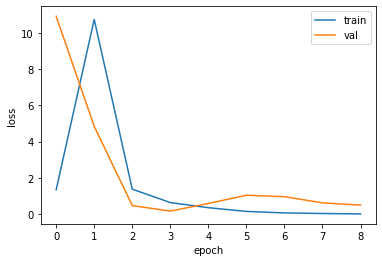

In [34]:
# 시각화 해보기
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [26]:
# 검증 데이터
model.evaluate(valData,valTargetData)

1/1 [==============================] - 0s 273ms/step - loss: 0.3740 - accuracy: 0.8182


[0.3739980459213257, 0.8181818127632141]

---
### 이미지로 확인해보기

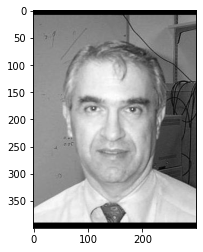

In [35]:
plt.imshow(valData[0].reshape(400,300),cmap='gray')
plt.show()

In [36]:
preds = model.predict(valData[0:1])
preds

1/1 [==============================] - 0s 348ms/step


array([[4.3531726e-04, 9.9720508e-01, 2.3595875e-03]], dtype=float32)

In [37]:
dirNames[np.argmax(preds[0])]

'Andrew'

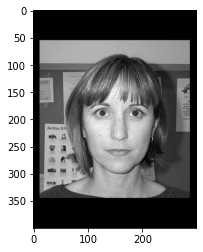

In [38]:
plt.imshow(valData[2].reshape(400,300),cmap='gray')
plt.show()

In [39]:
preds = model.predict(valData[2:3])
dirNames[np.argmax(preds[0])]

1/1 [==============================] - 0s 64ms/step


'Cathy'

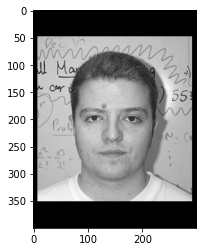

In [41]:
plt.imshow(valData[3].reshape(400,300),cmap='gray')
plt.show()